# Auto Insurance dataset

## Data Exploration

In this notebook, we will explore the auto insurance dataset produced for this 2017 [Kaggle challenge](https://www.kaggle.com/c/auto-insurance-fall-2017) in order to obtain some insight in predicting the possibility of an insurance claim from some data about the owner of the car, its habits and the car itself.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

sns.set_theme(
    context='talk',
    style='whitegrid',
    palette='pastel'
)
plt.rcParams["figure.figsize"] = (16,9)

### Preprocessing
The data are of different kind, and the dataset is pretty diverse: there are some boolean columns, some numerical (but with some expressed in dollars) and some other with textual categories. Thus, it is necessary to perform some cleaning before looking at the actual data.

In [2]:
dataset_raw = pd.read_csv('data/auto-insurance-fall-2017/train_auto.csv',
                          true_values=['yes', 'Yes', 'YES'],
                          false_values=['no', 'No', 'NO', 'z_No'],
                          index_col='INDEX'
                         )

dataset_raw.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",False,$0,False,...,"$14,230",11,Minivan,True,"$4,461",2,False,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",False,"$257,252",False,...,"$14,940",1,Minivan,True,$0,0,False,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",False,"$124,191",True,...,"$4,010",4,z_SUV,False,"$38,690",2,False,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,False,"$306,251",True,...,"$15,440",7,Minivan,True,$0,0,False,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",False,"$243,925",True,...,"$18,000",1,z_SUV,False,"$19,217",2,True,3,17.0,Highly Urban/ Urban


In [3]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   bool   
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   bool   
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   bool   
 19  OLDCL

The first thing to do is drop the unneeded columns (`TARGET_AMT` gives an indication of the amount required in the claim, which is of course useless in this exercise as it predicts with certainity the target flag), and create a variable for the label `TARGET_FLAG`.

Moreover, we clean some of the strings to have cleaner results and we tell pandas to use the best available type for each column.

In [4]:
# DROP UNUSED COLUMNS
train = dataset_raw.drop(columns="TARGET_AMT")

# SELECT LABEL
labels = train.pop('TARGET_FLAG').astype('bool').to_numpy()

# CLEAN STRINGS
train = train.apply(lambda x: x.str.replace('z_', '') if x.dtype == object else x)

# RATIONALISE TYPES
train = train.convert_dtypes()

Here we transform the columns with values expressed in dollars to obtain floating point valued columns. Moreover, the function `clean_money_columns` performs (if required) the logarithm of each column and the standard scaling (*i.e.* the affine transformation that makes the mean to be 0 and the standard deviation to be 1). Finally, it creates a new feature (an indicator column) for each of the original features that shows if the value is exactly 0 or not.

In [5]:
# CLEAN MONEY COLUMNS
money_cols = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
train = clean_money_columns(train, money_cols, log=True, scale=False, indicator=True)

A couple of columns have a numerical value which is actually a category, for instance the number of kids allowed to drive and the number of kids in the household, or the number of made claims. Thus, we convert them into string to ease the transformation into categorical columns.

Finally, a function `clean_types` is used to enforce a standardization of the types of each column and the transformation of the string columns in categorical columns.

In [6]:
# CATEGORICAL COLUMNS WITH NUMERICAL VALUES
categoricals = ["KIDSDRIV", "HOMEKIDS", "CLM_FREQ"]
for col in categoricals:
    train[col] = train[col].astype(str)

# ENFORCE TYPE CONSISTENCY
train = clean_types(train, verbose=False)

### Basic Statistics

Now we show the basics statistics for the data, *i.e.* the sample size, the number of feature after the previous cleaning, the ratio of positive values in the response variable (to check for data imbalance) and the percentage of missing values in each column.

In [7]:
sample_size, n_features = train.shape

print(f"{'Sample size':<20}: {sample_size:<6}")
print(f"{'N of Features':<20}: {n_features:<6}")

print(f"{'Positive examples':<20}: {100. * sum(labels) / sample_size:.1f} %")
print("\n============\n")
for name, column in train.items():
    na_perc = 100. * sum(pd.isna(column)) / sample_size
    print(f"{name:<12} is of type  {str(column.dtype):<10}", end='')
    if na_perc > 0:
        print(f" | {na_perc:.2f} % of missing values")
    else:
        print("")

Sample size         : 8161  
N of Features       : 27    
Positive examples   : 26.4 %


AGE          is of type  Int64      | 0.07 % of missing values
YOJ          is of type  Int64      | 5.56 % of missing values
INCOME       is of type  float64    | 5.45 % of missing values
HOME_VAL     is of type  float64    | 5.69 % of missing values
TRAVTIME     is of type  Int64     
BLUEBOOK     is of type  float64   
TIF          is of type  Int64     
OLDCLAIM     is of type  float64   
MVR_PTS      is of type  Int64     
CAR_AGE      is of type  Int64      | 6.25 % of missing values
KIDSDRIV     is of type  category  
HOMEKIDS     is of type  category  
SEX          is of type  category  
EDUCATION    is of type  category  
JOB          is of type  category   | 6.45 % of missing values
CAR_USE      is of type  category  
CAR_TYPE     is of type  category  
CLM_FREQ     is of type  category  
URBANICITY   is of type  category  
PARENT1      is of type  boolean   
MSTATUS      is of type  bool

We have then 8161 examples on the train set, of which around 26% produces a positive outcome. Thus, we don't need to worry about data imbalance: it is not perfectly 50 - 50 but most algorithms are able to deal with such a difference without any problems. 

Regarding the missing values, we have 6 columns which presents at least one missing value, 5 of which having around 5-6% of them. It is not a negligible quantity, thus we will need to take some care while building our models.

### Data exploration

We start the actual exploration by checking the categorical columns: how many unique values they have, and how unbalanced they are.

In [8]:
train.select_dtypes('category').describe().T

,count,unique,top,freq
KIDSDRIV,8161,5,0,7180
HOMEKIDS,8161,6,0,5289
SEX,8161,2,F,4375
EDUCATION,8161,5,High School,2330
JOB,7635,8,Blue Collar,1825
CAR_USE,8161,2,Private,5132
CAR_TYPE,8161,6,SUV,2294
CLM_FREQ,8161,6,0,5009
URBANICITY,8161,2,Highly Urban/ Urban,6492


As it can be seen, there is one variable that have 8 unique values while the other each have less than 6. This means that, considering the dimension of the dataset, we can build a one hot encoding for each categorical variable without having to worry about the parameters estimation of the model, as the number of features that we will obtain will still be manageable.


Then, we do the same for the boolean variables, observing how some of them are highly unbalanced.

In [9]:
train.select_dtypes(bool).describe().T

,count,unique,top,freq
PARENT1,8161,2,False,7084
MSTATUS,8161,2,True,4894
RED_CAR,8161,2,False,5783
REVOKED,8161,2,False,7161
INCOME_ind,7716,2,False,7101
HOME_VAL_ind,7697,2,False,5403
BLUEBOOK_ind,8161,1,False,8161
OLDCLAIM_ind,8161,2,True,5009


Finally we go on to observe the numerical columns, starting from the integer ones and then observing the floating point valued ones.

In [10]:
train.select_dtypes(int).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
AGE,8155.0,44.790313,8.627589,16.0,30.0,39.0,45.0,51.0,59.0,81.0
YOJ,7707.0,10.499286,4.092474,0.0,0.0,9.0,11.0,13.0,15.0,23.0
TRAVTIME,8161.0,33.485725,15.908333,5.0,7.0,22.0,33.0,44.0,60.0,142.0
TIF,8161.0,5.351305,4.146635,1.0,1.0,1.0,4.0,7.0,13.0,25.0
MVR_PTS,8161.0,1.695503,2.147112,0.0,0.0,0.0,1.0,3.0,6.0,13.0
CAR_AGE,7651.0,8.328323,5.700742,-3.0,1.0,1.0,8.0,12.0,18.0,28.0


Regarding the integer columns, there are not many surprises aside from the fact that, apparently, there is one negative value in the `CAR_AGE` column. Considering that the column already has some missing values, this $-3$ is probably an error in the dataset compilation. We can fix it either by changing it to a missing value or by converting it to a positive number with the same magnitude. We chose the first one as we have no way of being sure of what is happening in this case and, as there are already some missing values in this column it is, in my opinion, the minimally invasive intervention.

In [11]:
train.loc[train['CAR_AGE'] < 0, 'CAR_AGE'] = pd.NA

We finally plot the histograms for the numerical values, comparing with respect the labels to see if some of the features have a particular impact on the classification.

As is clear from the plots, this is not the case.

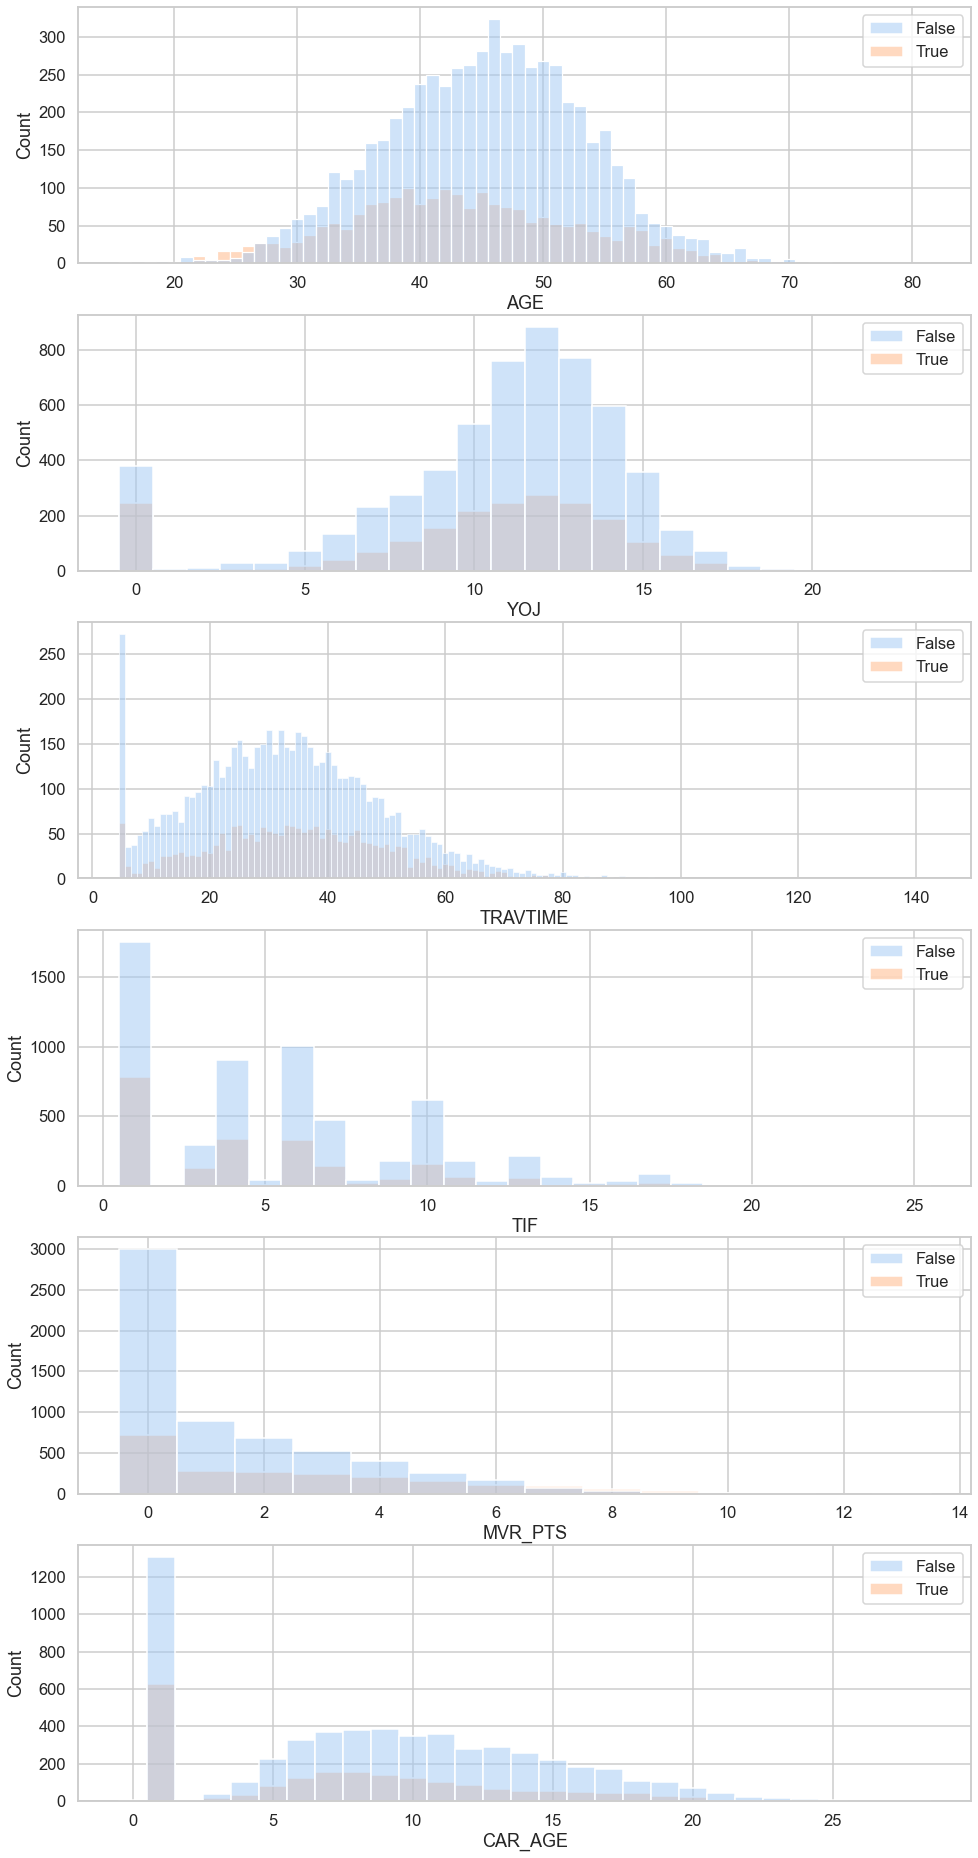

In [12]:
num = len(train.select_dtypes(int).columns)
f, ax = plt.subplots(num, 1, figsize=(16, num * 5.5))
i = 0
for name, column in train.select_dtypes(int).items():
    sns.histplot(x=column, hue=labels, discrete=True, stat='count', ax=ax[i])
    i += 1
plt.show()

The same descriptive analysis is done for the real-valued columns (which corresponds to the columns in dollars). Also here, nothing interesting or particularly helpful appears.

In [13]:
train.select_dtypes(float).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
INCOME,7716.0,2.670521e-16,1.0,-3.253947,-3.253947,0.091312,0.304834,0.456586,0.643221,0.930528
HOME_VAL,7697.0,-5.354226e-17,1.0,-1.531268,-1.531268,-1.531268,0.610659,0.680848,0.761464,0.914973
BLUEBOOK,8161.0,1.397404e-15,1.0,-3.457820,-1.581537,-0.569068,0.131940,0.714389,1.348892,2.628851
OLDCLAIM,8161.0,1.218919e-16,1.0,-0.785153,-0.785153,-0.785153,-0.785153,1.172603,1.581958,1.754620


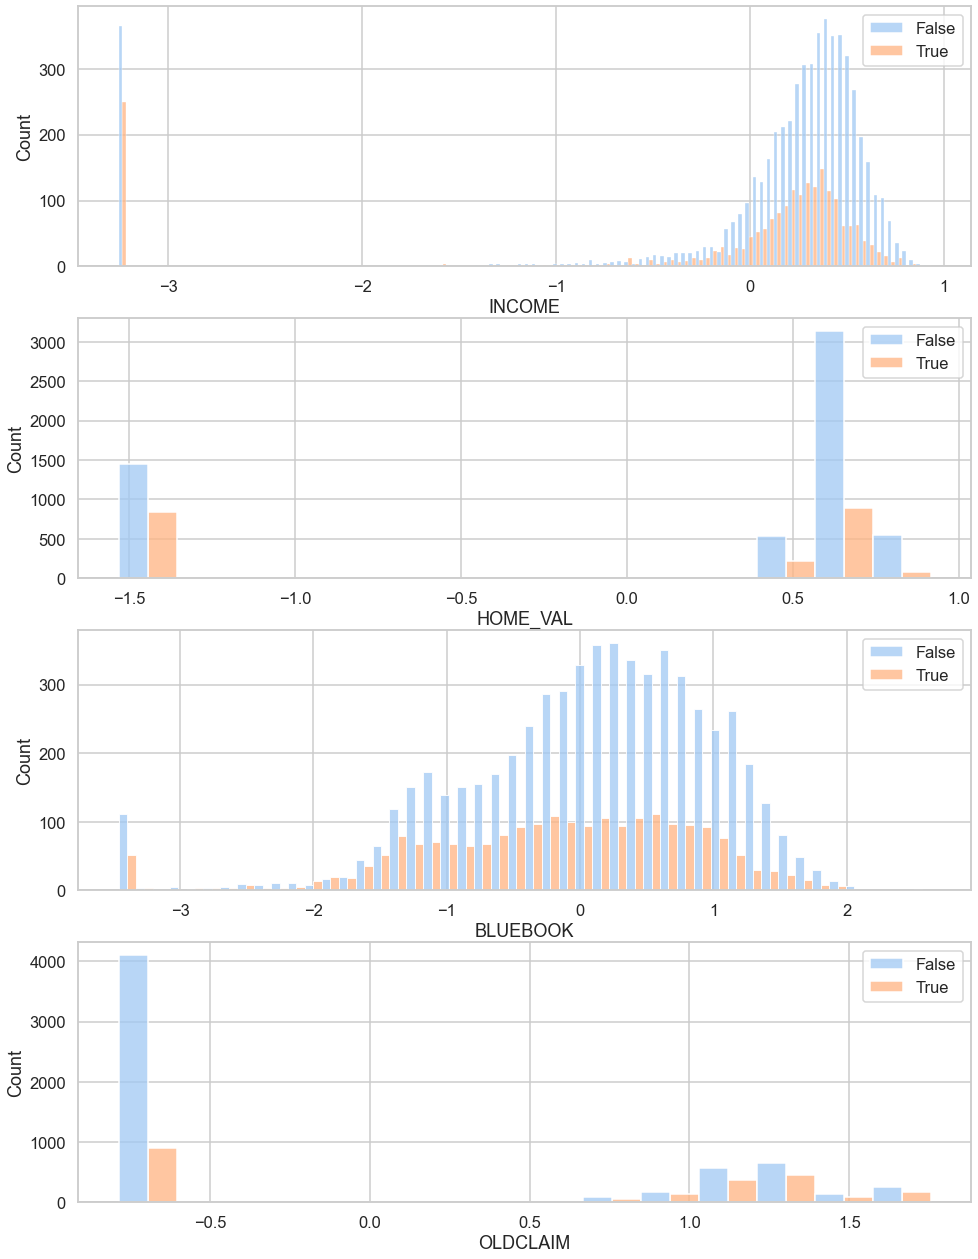

In [14]:
num = len(train.select_dtypes(float).columns)
f, ax = plt.subplots(num, 1, figsize=(16, num * 5.5))
i = 0
for name, column in train.select_dtypes(float).items():
    sns.histplot(x=column, hue=labels, stat='count', ax=ax[i])
    i += 1
plt.show()